In [76]:
#get notebook runtime
from timeit import default_timer as timer
start = timer()

In [77]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [78]:
import warnings
warnings.filterwarnings('ignore')

In [79]:
import seaborn as sns
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

### Characteristics

Let's recall the characteristics of our dataset:

In [80]:
#get notebook runtime
start = timer()

In [81]:
df = pd.read_parquet("../data/df_cleaned_21_08_2021.parquet")

In [82]:
df.shape

(1089891, 43)

In [83]:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_HOUR,PU_isWorkday,DO_MONTH_NAME,DO_WEEKDAY_NAME,DO_WEEK,DO_DATE,DO_MONTH,DO_WEEKDAY,DO_HOUR,DO_isWorkday
489487,5487de4e97b71188efadf95669f532a5ccb08843,56f2fce86600dd132681be1323fe78ce26e60f2fffe4b3...,2017-01-09 11:45:00,2017-01-09 12:00:00,480.0,0.10,NaN,NaN,8.0,7.0,...,12,True,January,Monday,2,2017-01-09,1,0,12,True
16284335,491aabe21dbd65e2fa8efca4cdf7d6bf40f45b89,edcd6d939a065b4d0028d5219351a593d77b1b17637db3...,2017-08-17 14:30:00,2017-08-17 14:30:00,240.0,0.90,1.703132e+10,1.703108e+10,32.0,8.0,...,15,True,August,Thursday,33,2017-08-17,8,3,15,True
4052837,522fe170918a41a9eacb8c665b5a699be9db33c8,fbdfc1bdf8477e6043d2012f98283fdbc6212192a065ab...,2017-03-03 07:30:00,2017-03-03 07:45:00,360.0,0.20,NaN,NaN,6.0,8.0,...,8,True,March,Friday,9,2017-03-03,3,4,8,True
14574858,0fc17e1ac2fbdbe5ce772521e712341bb5b19d64,e428b282d868d83ee36a566f79e7e8926c9c3c631809cc...,2017-07-23 10:30:00,2017-07-23 10:30:00,401.0,1.19,1.703132e+10,1.703108e+10,32.0,8.0,...,11,False,July,Sunday,30,2017-07-23,7,6,11,False
3642582,53278beb03b150357771f184b6b0787eec16c095,5e3077a68e0439a1168a98d848e9ae3fd8c74f61bc4323...,2017-02-25 10:00:00,2017-02-25 10:30:00,1496.0,17.50,1.703198e+10,1.703108e+10,76.0,8.0,...,11,False,February,Saturday,8,2017-02-25,2,5,11,False


In [84]:
df.isnull().sum()

Trip ID                            0
Taxi ID                          401
Trip Start Timestamp               0
Trip End Timestamp                 0
Trip Seconds                       0
Trip Miles                         0
Pickup Census Tract           328349
Dropoff Census Tract          331418
Pickup Community Area          78095
Dropoff Community Area         98584
Fare                               0
Tips                               0
Tolls                         284734
Extras                             0
Trip Total                         0
Payment Type                       0
Company                            0
Pickup Centroid Latitude       78095
Pickup Centroid Longitude      78095
Dropoff Centroid Latitude      98584
Dropoff Centroid Longitude     98584
PU_H3                          78095
DO_H3                          98584
PU_DISTANCE_CITY               78095
DO_DISTANCE_CITY               98584
DURATION_IN_MINUTES                0
MPH                                0
P

In [85]:
df_pairplot = df[:100]

In [86]:
#sns.pairplot(df_pairplot, hue='PU_H3')

Nun schauen wir uns explizit die Korrelationen der Variablen an. Wie ebenfalls im vorigen Plot zu observieren, sehen wir hier, dass die Variablen zum Teil stark positiv sowie negativ korrelieren.

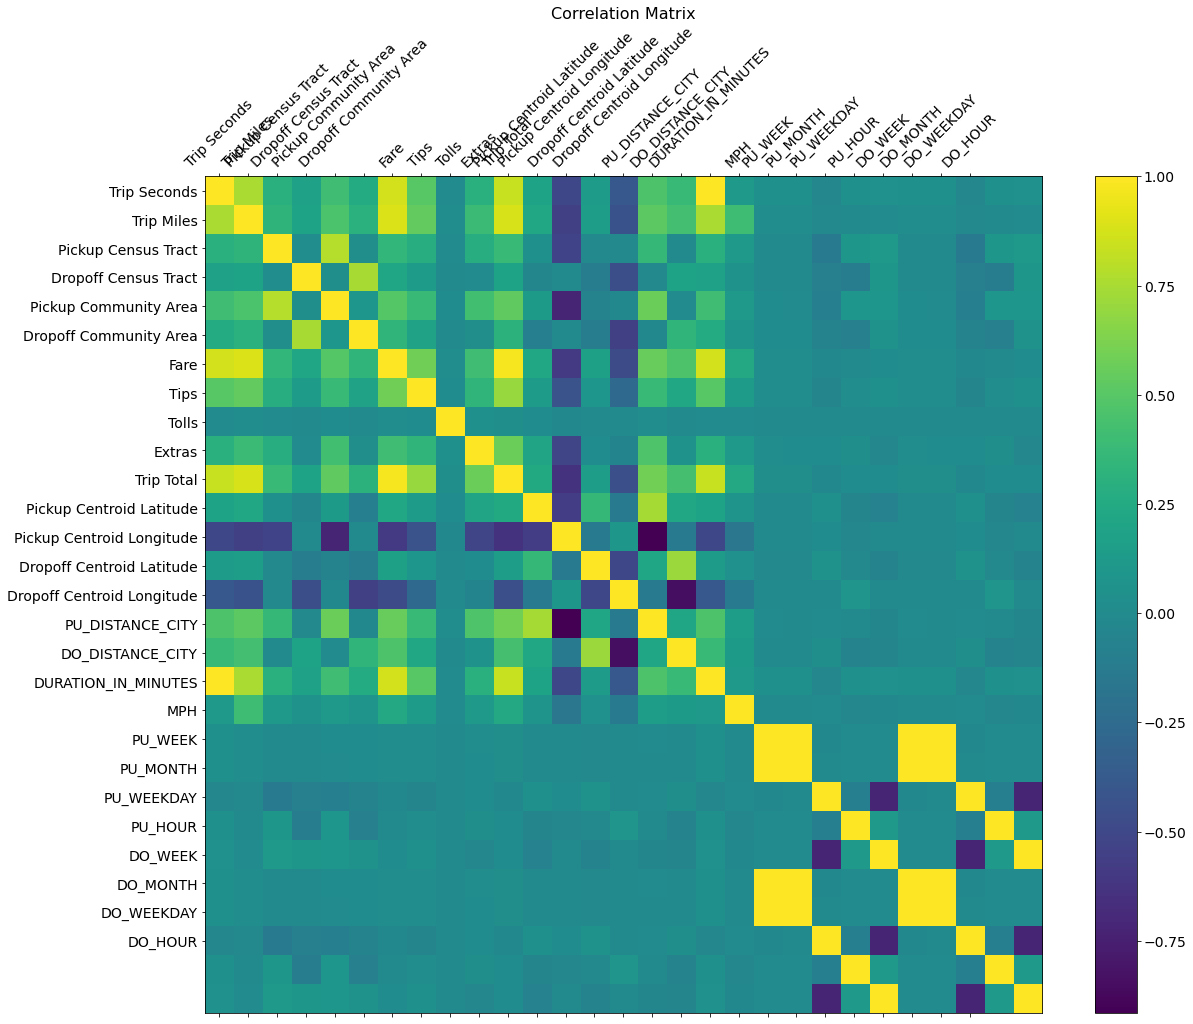

In [87]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Nun schauen wir uns die Verteilung unserer Zielvariablen taxi_demand (auf stündlicher basis) genauer an. Es ist zu erkennen, dass Samstags und Sonntags wesentlich häufiger früh am morgen das Taxi genutzt wird, als unter der Woche.

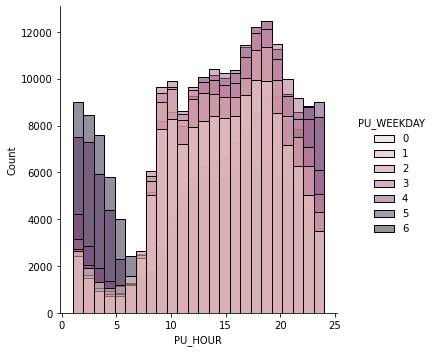

In [88]:
sns.displot(df,x='PU_HOUR', hue='PU_WEEKDAY', bins=24)


## 4. SVM

### Data Preparation for 4.1 SVM and 4.2 NN

Let's start with a reuseable function to get a dataframe of the selected temporal and spatial resolution. To obtain robust values for the predictors, we use the median.

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import h3


In [90]:
#TODO: Felix input for feature selection

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089891 entries, 489487 to 2034369
Data columns (total 43 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Trip ID                     1089891 non-null  object        
 1   Taxi ID                     1089490 non-null  object        
 2   Trip Start Timestamp        1089891 non-null  datetime64[ns]
 3   Trip End Timestamp          1089891 non-null  datetime64[ns]
 4   Trip Seconds                1089891 non-null  float64       
 5   Trip Miles                  1089891 non-null  float64       
 6   Pickup Census Tract         761542 non-null   float64       
 7   Dropoff Census Tract        758473 non-null   float64       
 8   Pickup Community Area       1011796 non-null  float64       
 9   Dropoff Community Area      991307 non-null   float64       
 10  Fare                        1089891 non-null  float64       
 11  Tips               

In [93]:
chicago_com_areas = gpd.read_file("../data/chicago-community-areas.geojson")
chicago_com_areas["area_num_1"]=chicago_com_areas["area_num_1"].astype(int)
chicago_com_areas["centroid"] = chicago_com_areas["geometry"].centroid

In [126]:
weather_df = pd.read_parquet("../data/weather_transformed_22_08_2021.parquet")
weather_df["hour"] = weather_df["datetime"].dt.hour
weather_df["has_precipitation"] = weather_df["has_precipitation"].astype(int)
weather_df.drop(columns=["month","datetime"],inplace=True)
weather_df.sample(10)

,Temperature,Humidity,Wind Speed,weather_description,date,has_precipitation,precipitation_intensity,hour
6028,288.220,63.0,4.0,broken clouds,2017-09-09,0,2,4
221,273.360,80.0,6.0,light snow,2017-01-10,1,1,5
5831,294.160,68.0,5.0,haze,2017-08-31,0,2,23
2143,277.140,93.0,5.0,light rain,2017-03-31,1,1,7
5694,287.320,77.0,2.0,sky is clear,2017-08-26,0,2,6
5901,300.740,28.0,5.0,scattered clouds,2017-09-03,0,2,21
3547,295.470,69.0,6.0,scattered clouds,2017-05-28,0,2,19
1091,269.842,100.0,7.0,sky is clear,2017-02-15,0,2,11
7931,273.140,100.0,1.0,mist,2017-11-27,0,2,11
2242,281.480,93.0,4.0,overcast clouds,2017-04-04,0,2,10


In [122]:
import numpy as np
def get_data(df,weather_df,temp_resolution,spatial_resolution=False,):
    
    #Filter out all Data that doesn't have Pickup Location Data
    dff = df[df["PU_H3"].isnull()!=True]
    
    
    #---- Calculate new H3 based on specified resolution (if it is higher than resolution in dataset) -----#
    h3_base_resolution = h3.h3_get_resolution(dff["PU_H3"].iloc[0]) #get original resolution in data
    
    if h3_base_resolution<spatial_resolution:
        print("ERROR: Trying to select smaller resolution than available in dataset. Keeping data on resolution",h3_base_resolution)
        dff["PU_H3_pred"] = dff["PU_H3"]
        dff["DO_H3_pred"] = dff["DO_H3"]
        
    if h3_base_resolution == spatial_resolution:
        dff["PU_H3_pred"] = dff["PU_H3"]
        dff["DO_H3_pred"] = dff["DO_H3"]
        
    if spatial_resolution and spatial_resolution<h3_base_resolution:
        #calculate new H3s with centroids of old H3s
        dff["PU_H3_pred"] = dff.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"],x["Pickup Centroid Longitude"],spatial_resolution),axis=1)
        dff["DO_H3_pred"] = dff.apply(lambda x: h3.geo_to_h3(x["Dropoff Centroid Latitude"],x["Dropoff Centroid Longitude"],spatial_resolution),axis=1)
        
    #---------------------------------------------------------------------------------------------------#
    dff_h3 = dff.groupby(["PU_H3_pred",
                               "PU_DATE",
                               "PU_HOUR"]).agg(H3_index=("PU_H3_pred","first"),
                                               DATE_index=("PU_DATE","first"),
                                               HOUR_index=("PU_HOUR","first"),
                                               count=("PU_H3","count"),
                                               MONTH=("PU_MONTH","first"),
                                               DISTANCE_CITY=("PU_DISTANCE_CITY","median"),
                                               WEEKDAY=("PU_WEEKDAY","first"),
                                               isWorkday=("PU_isWorkday","first"))
    
    
    dff_h3 = pd.merge(dff_h3,weather_df,left_on=["DATE_index","HOUR_index"],right_on=["date","hour"],how="left")
    print(dff_h3.head())

    #--------------------------- Slice Hours of Days into set Temporal Resolution ---------------------------#
    # This slices the day into equal parts. Input is the amount of slices per day.
    slicer = 24 / temp_resolution
    
    dff_h3["PU_HOUR_slice"] = np.ceil(dff_h3["HOUR_index"]/slicer).astype(int)
    #--------------------------------------------------------------------------------------------------------#
    
    
    
    #--------------------------- Grouping ---------------------------#
    dff_grouped = dff_h3.groupby(["H3_index",
                                       "DATE_index",
                                       "PU_HOUR_slice"]).agg(H3=("H3_index","first"),
                                                             DATE=("DATE_index","first"),
                                                             HOUR_slice=("PU_HOUR_slice","first"),
                                                             count=("count","sum"),#sums over all hours in slice
                                                             MONTH=("MONTH","first"),
                                                             MIN_HOUR=("HOUR_index","min"),
                                                             MAX_HOUR=("HOUR_index","max"),
                                                             DISTANCE_CITY=("DISTANCE_CITY","median"),
                                                             WEEKDAY=("WEEKDAY","first"),
                                                             isWorkday=("isWorkday","first"),
                                                             Temperature=("Temperature","median"),
                                                             Humidity=("Humidity","median"),
                                                             Wspeed=("Wind Speed","median"),
                                                             weather_description=("weather_description","first"),#TODO eher meiste
                                                             has_precipitation = ("has_precipitation","sum"),
                                                             precipitation_intensity=("precipitation_intensity","max"))
        
    #----------------------------------------------------------------#
    return dff_grouped
 
df_pred=get_data(df,weather_df,4,8)

df_pred

          H3_index  DATE_index  HOUR_index  count  MONTH  DISTANCE_CITY  \
0  8826641901fffff  2017-04-27           9      1      4      20.797098   
1  8826641901fffff  2017-06-05          15      1      6      20.607303   
2  8826641903fffff  2017-08-02          14      1      8      21.715091   
3  8826641903fffff  2017-10-26          14      1     10      21.783883   
4  8826641903fffff  2017-11-25          11      1     11      21.783883   

   WEEKDAY  isWorkday  Temperature  Humidity  Wind Speed weather_description  \
0        3       True       289.15      87.0         5.0                mist   
1        0       True       296.12      50.0         3.0        sky is clear   
2        2       True       295.15      78.0         1.0                mist   
3        3       True       277.53      75.0         3.0       broken clouds   
4        5      False       279.75      70.0         4.0        sky is clear   

         date has_precipitation  precipitation_intensity  hour  
0  

H3        DATE  \
H3_index        DATE_index PU_HOUR_slice                                
8826641901fffff 2017-04-27 2              8826641901fffff  2017-04-27   
                2017-06-05 3              8826641901fffff  2017-06-05   
8826641903fffff 2017-08-02 3              8826641903fffff  2017-08-02   
                2017-10-26 3              8826641903fffff  2017-10-26   
                2017-11-25 2              8826641903fffff  2017-11-25   
...                                                   ...         ...   
88275936ddfffff 2017-03-16 1              88275936ddfffff  2017-03-16   
                2017-03-24 4              88275936ddfffff  2017-03-24   
                2017-05-05 1              88275936ddfffff  2017-05-05   
                2017-09-20 2              88275936ddfffff  2017-09-20   
                2017-10-05 1              88275936ddfffff  2017-10-05   

                                          HOUR_slice  count  MONTH  MIN_HOUR  \
H3_index        DATE_index PU_HOUR_slice                                       
8826641901fffff 2017-04-27 2                       2      1      4         9   
                2017-06-05 3                       3      1      6        15   
8826641903fffff 2017-08-02 3                       3      1      8        14   
                2017-10-26 3                       3      1     10        14   
                2017-11-25 2                       2      1     11        11   
...                                              ...    ...    ...       ...   
88275936ddfffff 2017-03-16 1                       1      1      3         4   
                2017-03-24 4                       4      1      3        20   
                2017-05-05 1                       1      1      5         5   
                2017-09-20 2                       2      1      9         7   
                2017-10-05 1                       1      1     10         4   

                                          MAX_HOUR  DISTANCE_CITY  WEEKDAY  \
H3_index        DATE_index PU_HOUR_slice                                     
8826641901fffff 2017-04-27 2                     9      20.797098        3   
                2017-06-05 3                    15      20.607303        0   
8826641903fffff 2017-08-02 3                    14      21.715091        2   
                2017-10-26 3                    14      21.783883        3   
                2017-11-25 2                    11      21.783883        5   
...                                            ...            ...      ...   
88275936ddfffff 2017-03-16 1                     4      22.467770        3   
                2017-03-24 4                    20      22.115757        4   
                2017-05-05 1                     5      22.267426        4   
                2017-09-20 2                     7      21.914831        2   
                2017-10-05 1                     4      21.914831        3   

                                          isWorkday  Temperature  Humidity  \
H3_index        DATE_index PU_HOUR_slice                                     
8826641901fffff 2017-04-27 2                   True       289.15      87.0   
                2017-06-05 3                   True       296.12      50.0   
8826641903fffff 2017-08-02 3                   True       295.15      78.0   
                2017-10-26 3                   True       277.53      75.0   
                2017-11-25 2                  False       279.75      70.0   
...                                             ...          ...       ...   
88275936ddfffff 2017-03-16 1                   True       268.70      49.0   
                2017-03-24 4                   True       299.74      36.0   
                2017-05-05 1                   True       280.44      70.0   
                2017-09-20 2                   True       290.25      93.0   
                2017-10-05 1                   True       289.54      93.0   

                                  

In [111]:
def get_data(df, temp_resolution, spatial_resolution=False):
    
    h3_base_resolution = h3.h3_get_resolution(df["PU_H3"].iloc[0]) #get original resolution in data
    
    #Calculate new H3 based on specified resolution (if it is higher than resolution in dataset)
    if h3_base_resolution>spatial_resolution:
        print("ERROR: Trying to select smaller resolution than available in raw data")
        
    if spatial_resolution and spatial_resolution>h3_base_resolution:
    '''df["PU_H3"] = df.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"],
                                                  x['Pickup Centroid Longitude'],
                                                  spatial_resolution),axis=1)
    df["PU_H3"] = df["PU_H3"].replace("0",np.nan)'''
    
    
    
    
    
    
    #
    PU_H3_dummies = pd.get_dummies(df.PU_H3)#get dummies for H3 for prediction (alternative: use H3 centroids)
    df = pd.concat([df, PU_H3_dummies], axis=1)
    
    #group by temporal and spacial resolution
    df_new = df.groupby(['PU_H3', pd.Grouper(key="Trip Start Timestamp", freq=temp_resolution)]).median()#create df based on temporal and spacial specifications
    df_new['count'] = df.groupby(['PU_H3', pd.Grouper(key="Trip Start Timestamp", freq=temp_resolution)]).size()#add demand for each unit of analysis; note that the frame is grouped by two features
    df_new.dropna(inplace=True)
    print("Dataframe after applying temporal and spacial specifications: ")#debug information
    print("Shape: ",df_new.shape)
    print("Demand description for temporal/spatial units (e.g. 2017-01-01 09:00, 8826641915fffff): ")
    #print(df_new['count'].describe())
    
    #select target and predictors
    y = df_new['count']
    X = df_new.drop('count', axis=1)
    print('Debug Information')
    print('-------------------------------')
    print("Shape Featureset/Target: ", X.shape, y.shape)
    #print(X.iloc[0])
    
    #split data
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=38)
    
    #scale data
    scaler = StandardScaler()
    scaler.fit(x_train) #fit scaler
    X_train_scaled = scaler.transform(x_train) #apply to both, train and test set
    X_test_scaled = scaler.transform(x_test)
    print("Shape after scaling trainingset: ", X_train_scaled.shape, y_train.shape)
    print("Shape after scaling testset: ", X_test_scaled.shape, y_test.shape)
    
    #select best features
    selector = SelectKBest(f_classif, k=40)
    selector.fit(X_train_scaled, y_train)
    cols = selector.get_support(indices=True)#get selected columns
    X_train_new = X_train_scaled[:,cols]#apply to train&test set
    X_test_new = X_test_scaled[:,cols]
    print("X_Train:", X_train_new.shape, "X_Test:", X_test_new.shape)
    
    return X_train_new, X_test_new, y_train, y_test

IndentationError: expected an indented block (<ipython-input-111-90462b7db2dd>, line 13)

### 4.1.1 SVM Prediction

First, we define a training method and to use it for training our models. Consequently, we will start with simple models and improve them for better performance. 

In [19]:
#function to train and evaluate our models later on
import sklearn.metrics as metrics
import numpy as np

def train(model, model_name, x_train, x_test, y_train, y_test, element):
    
    print()
    print(model_name, element) # Printing model name
    print('-------------------------------')
    model.fit(x_train,y_train) # fitting the defined model
    pred = model.predict(x_test) # predicting our data

    acc = metrics.r2_score(y_test, pred) #Checking R2_Score
    print('R2_Score',acc)

    met = np.sqrt(metrics.mean_squared_error(y_test, pred)) #Calculating RMSE
    print('RMSE : ', met) 

    var = (metrics.explained_variance_score(y_test, pred)) #Calculating explained_variance_score
    print('Explained_Variance : ', var)

    error = (metrics.max_error(y_test, pred)) #Calculating Max_Error
    print('Max_Error : ', error)
    
    err = metrics.mean_absolute_error(y_test, pred) #Calculating mean_absolute_error
    print("Mean Absolute Error", err)
    print()
    print()
    
    return model_name + '($R^2={:.3f}$)'.format(acc), np.array(y_test), pred

In [20]:
#select data to start with, we use a daily level for our inital modeling 

X_train_new, X_test_new, y_train, y_test = get_data(df, temp_resolution="24H")

Dataframe after applying temporal and spacial specifications: 
Shape:  (4963, 47)
Demand description for temporal/spatial units (e.g. 2017-01-01 09:00, 8826641915fffff): 
Debug Information
-------------------------------
Shape Featureset/Target:  (4963, 46) (4963,)
Shape after scaling trainingset:  (2977, 46) (2977,)
Shape after scaling testset:  (1986, 46) (1986,)
X_Train: (2977, 40) X_Test: (1986, 40)


In [21]:
#Start without a Kernel
results=[] #save results-tuple for visualization
model_svr = SVR()
results.append(train(model_svr, "SVR", X_train_new, X_test_new,
                     y_train, y_test, "24H" ))


SVR 24H
-------------------------------
R2_Score -0.09931873004111558
RMSE :  1572.3762838301266
Explained_Variance :  0.06630141234650444
Max_Error :  7155.638653015645
Mean Absolute Error 674.1502040129623




In [22]:
#Make more complex
model_svr2 = SVR(kernel='linear')
results.append(train(model_svr2, "SVR_Linear", X_train_new, X_test_new,
                     y_train, y_test, "24H"))


SVR_Linear 24H
-------------------------------
R2_Score 0.810303693188717
RMSE :  653.1668106704607
Explained_Variance :  0.8268322309326513
Max_Error :  3909.6355806543115
Mean Absolute Error 270.7641776055762




Parameters are as follows:
**C:** It is the regularization parameter, C, of the error term.
**kernel:** It specifies the kernel type to be used in the algorithm. It can be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, or callable. The default value is ‘rbf’.
**degree:** It is the degree of the polynomial kernel function (‘poly’) and is ignored by all other kernels. The default value is 3.
**gamma:** It is the kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’. If gamma is ‘auto’, then 1/n_features will be used instead.

In [25]:
#Tune Hyperparams
from sklearn.model_selection import GridSearchCV

param_grid = { 'C':[0.1,1,100,1000],'kernel':['poly','linear'],
              'degree':[1,2,3,4,5,6],'gamma': [1e-7, 1e-4]}
grid = GridSearchCV(SVR(),param_grid)
grid.fit(X_train_new,y_train)#loop through predefined number of hyperparameters

print(grid.best_params_)
print(grid.score(X_test_new,y_test))

{'C': 100, 'degree': 1, 'gamma': 1e-07, 'kernel': 'linear'}
0.9092864736516538


In [30]:
#Run Model with tuned hyperparams
model_svr3 = SVR(kernel='linear', C=100)
results.append(train(model_svr3, "SVR_Linear", X_train_new, X_test_new,
                     y_train, y_test, "24H"))


SVR_Linear 24H
-------------------------------
R2_Score 0.9092864736516538
RMSE :  451.67982848271794
Explained_Variance :  0.909699169899579
Max_Error :  2983.1924320871794
Mean Absolute Error 186.71099375708434




### 4.1.2 Model Evaluation (Visually)

In this section, we will examine the performance of our models more closely. For this, we will look at the visual characteristics of our predictions.

In [ ]:
# Bessere Visualisierung einbauen

In [ ]:
#Create a plot comparing multiple learners
def plot(results):
    # Using subplots to display the results on the same X axis
    fig, plts = plt.subplots(nrows=len(results), figsize=(8, 8))
    fig.canvas.set_window_title('Predicting Chicago')

    # Show each element in the plots returned from plt.subplots()
    for subplot, (title, y, y_pred) in zip(plts, results):
        # Configure each subplot to have no tick marks
        # (these are meaningless for the sample dataset)
        subplot.set_xticklabels(())
        subplot.set_yticklabels(())

        # Label the vertical axis
        subplot.set_ylabel('Taxi Demand')
        subplot.set_xlabel('Time')

        # Set the title for the subplot
        subplot.set_title(title)

        # Plot the actual data and the prediction
        subplot.plot(y, 'b', label='actual')
        subplot.plot(y_pred, 'r', label='predicted')
        
        # Shade the area between the predicted and the actual values
        subplot.fill_between(
            # Generate X values [0, 1, 2, ..., len(y)-2, len(y)-1]
            np.arange(0, len(y), 1),
            y,
            y_pred,
            color='r',
            alpha=0.2
        )

        # Mark the extent of the training data
        subplot.axvline(len(y) // 2, linestyle='--', color='0', alpha=0.2)

        # Include a legend in each subplot
        subplot.legend()

    # Let matplotlib handle the subplot layout
    fig.tight_layout()
    plt.show()
    plt.savefig('plot.png')
    plt.close()

In [ ]:
plot(results)

### 4.1.3 Variation of Temporal and Spatial Resolution

In this section, we aim to explore the performance of our best model based on a variation of termporal and spatial resolutions.

In [ ]:
#TODO: Add Spatial Resolution
#77community areas
#866 census tracts (population between 0 - 10000)
#resolution 0-15, with 0 beeing the highest

In [ ]:
#generate datasets - temporal dimension
temporal_resolution_levels = ['24H', '6H', '2H', '1H']

results = []

for element in temporal_resolution_levels:
    model = SVR(kernel='linear')
    X_train_new, X_test_new, y_train, y_test = get_data(df, element)
    results.append(train(model, "SVR_Linear", X_train_new, X_test_new,
                         y_train, y_test, element))

end = timer()
print()
print("Total Notebook Runtime (s): ", end - start)

# Backup

In [ ]:
## Test
import contextily as ctx
import h3
import shapely.geometry
import geopandas as gpd


test_resolution = 6
iloc=51

PU_lat_test=df["Pickup Centroid Latitude"].iloc[iloc]
print(PU_lat_test)
PU_lng_test=df["Pickup Centroid Longitude"].iloc[iloc]
print(PU_lng_test)

point_test = shapely.geometry.Point(PU_lng_test,PU_lat_test)
point_gdf_test = gpd.GeoDataFrame(pd.DataFrame([point_test],index=[0],columns=["geometry"]))


h3_test = h3.geo_to_h3(PU_lat_test,PU_lng_test,test_resolution)
print(h3_test)

polygon_test = {"geometry":shapely.geometry.Polygon(h3.h3_to_geo_boundary(h3_test,geo_json=True))}
geo_df_test = gpd.GeoDataFrame(pd.DataFrame(polygon_test,index=[0]))

fig,ax=plt.subplots(figsize=(8,8))
geo_df_test.plot(ax=ax,alpha=0.1)
point_gdf_test.plot(ax=ax,alpha=0.8,color="red")
ctx.add_basemap(ax=ax,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_com_areas.plot(ax=ax,alpha=0.01) #das macht nur die skalierung richtig